In [1]:
import sys
import os
from tqdm import tqdm
# from src.models.setup_model import setup_sam2, load_sam2

# Aggiunge il percorso del progetto al PYTHONPATH
current_dir = os.path.abspath(os.getcwd())
project_home_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

sys.path.append(project_home_dir)

# # Carica il modello SAM2
# setup_sam2(project_home_dir)
# predictor = load_sam2(project_home_dir)

In [2]:
import src.data.make_dataset as make_dataset
import src.data.image_info as image_info

slice_dict = make_dataset.load_image_slices(os.path.join(project_home_dir, r"data\raw"))
masks_path_list = {
    'BZ2': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ2_preprocessed_collagen_tissue_mask.png",
    'BZ3': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ3_preprocessed_collagen_tissue_mask.png",
    'BZ5': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ5_preprocessed_collagen_tissue_mask.png",
    'BZ6': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ6_preprocessed_collagen_tissue_mask.png",
    'RE1': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_RE1_preprocessed_collagen_tissue_mask.png",
    'RE2': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_RE2_preprocessed_collagen_tissue_mask.png",
}


for slice_id in tqdm(slice_dict):
    mask_path = masks_path_list[slice_id]
    imageInfo = image_info.ImageSlice(slice_id)
    imageInfo.load_images(slice_dict[slice_id]['wga'], slice_dict[slice_id]['collagen'], slice_dict[slice_id]['autofluorescence'])
    imageInfo.analyse_image2(mask_path)
    imageInfo.save_results()

 17%|█▋        | 1/6 [01:48<09:04, 108.82s/it]

Results for slice BZ2 saved in C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\data\processed\slice_BZ2


 33%|███▎      | 2/6 [03:05<05:59, 89.86s/it] 

Results for slice BZ3 saved in C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\data\processed\slice_BZ3


 50%|█████     | 3/6 [04:53<04:54, 98.02s/it]

Results for slice BZ5 saved in C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\data\processed\slice_BZ5


 67%|██████▋   | 4/6 [06:22<03:09, 94.65s/it]

Results for slice BZ6 saved in C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\data\processed\slice_BZ6


 83%|████████▎ | 5/6 [08:19<01:42, 102.68s/it]

Results for slice RE1 saved in C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\data\processed\slice_RE1


100%|██████████| 6/6 [09:29<00:00, 94.89s/it] 

Results for slice RE2 saved in C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\data\processed\slice_RE2


In [2]:
import src.data.pre_process_image as pi
import cv2

mask_path = r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ2_preprocessed_collagen_tissue_mask.png"
path_autofluorescence = r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\data\raw\BZ2_BZ2_CH1_AUTO_MIP.tif"

autofluorescence_image = pi.load_tif_image(path_autofluorescence)
autofluorescence = pi.resize_image(autofluorescence_image, 0.5)
segmented_tissue = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
preprocessed_auto = pi.enhance_image(autofluorescence, segmented_tissue)

In [3]:
import cv2
import numpy as np

def clean_mask(mask, kernel_size=5):
    """Rimuove rumore e artefatti dalla maschera binaria usando operazioni morfologiche."""
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Rimuove piccoli pixel isolati
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)  # Riempie buchi nella maschera
    return mask_cleaned

def smooth_mask(mask, blur_size=5):
    """Applica un filtro Gaussiano per lisciare i bordi della maschera."""
    return cv2.GaussianBlur(mask, (blur_size, blur_size), 0)

def extract_contours(mask, min_area=500):
    """Trova tutti i contorni nella maschera e filtra quelli troppo piccoli."""
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

def create_final_mask(shape, contours):
    """Genera una nuova maschera binaria con tutti i contorni processati."""
    final_mask = np.zeros(shape, dtype=np.uint8)
    cv2.drawContours(final_mask, contours, -1, 255, thickness=cv2.FILLED)
    return final_mask

def postprocess_mask(mask):
    """Pipeline completa per il post-processing della maschera mantenendo tutti i contorni."""
    mask = clean_mask(mask)  # Pulizia artefatti
    mask = smooth_mask(mask)  # Lisciatura
    contours = extract_contours(mask)  # Estrazione di tutti i contorni significativi
    final_mask = create_final_mask(mask.shape, contours)  # Nuova maschera con tutti i contorni
    
    return final_mask, contours

mask= cv2.imread(r'C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\data\processed\slice_BZ2\slice_BZ2_segmented_cardios.png', cv2.IMREAD_GRAYSCALE)
mask_postprocessed, contours = postprocess_mask(mask)



In [4]:
print(contours)

[array([[[   0, 3599]],

       [[   0, 3669]],

       [[  12, 3669]],

       [[  13, 3668]],

       [[  16, 3668]],

       [[  17, 3667]],

       [[  19, 3667]],

       [[  20, 3666]],

       [[  21, 3666]],

       [[  22, 3665]],

       [[  22, 3664]],

       [[  24, 3662]],

       [[  24, 3660]],

       [[  25, 3659]],

       [[  25, 3647]],

       [[  24, 3646]],

       [[  24, 3645]],

       [[  23, 3644]],

       [[  23, 3643]],

       [[  22, 3642]],

       [[  22, 3641]],

       [[  21, 3640]],

       [[  21, 3639]],

       [[  20, 3638]],

       [[  20, 3637]],

       [[  19, 3636]],

       [[  19, 3635]],

       [[  18, 3634]],

       [[  18, 3632]],

       [[  17, 3631]],

       [[  17, 3630]],

       [[  16, 3629]],

       [[  16, 3627]],

       [[  15, 3626]],

       [[  15, 3622]],

       [[  14, 3621]],

       [[  14, 3611]],

       [[  13, 3610]],

       [[  13, 3604]],

       [[  12, 3603]],

       [[  12, 3599]]], dtype=int32), a

In [8]:
def overlay_contours(image, contours, thickness=2):
    """
    Sovrappone i contorni sull'immagine, ognuno con un colore specifico.
    
    Args:
        image (ndarray): Immagine RGB o scala di grigi.
        contours (list): Lista di contorni (ogni contorno è un array numpy con shape (N,1,2)).
        thickness (int): Spessore intero dei contorni (default: 2).
    
    Returns:
        ndarray: Immagine con contorni sovrapposti.
    """
    # Conversione a immagine RGB se in scala di grigi
    if len(image.shape) == 2:
        overlay_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        overlay_image = image.copy()
    
    # Tavolozza di colori
    colors = [
        (255, 0, 0),   # Rosso
        (0, 255, 0),   # Verde
        (0, 0, 255),   # Blu
        (255, 255, 0), # Giallo
        (0, 255, 255), # Ciano
        (255, 0, 255), # Magenta
    ]
    
    # Disegna ogni contorno
    for i, cnt in enumerate(contours):
        # Converti il contorno al formato richiesto da OpenCV se necessario
        if not isinstance(cnt, np.ndarray):
            cnt = np.array(cnt, dtype=np.int32).reshape((-1,1,2))
        color = colors[i % len(colors)]
        cv2.drawContours(overlay_image, [cnt], contourIdx=-1, color=color, thickness=int(thickness))
    
    return overlay_image

In [11]:
print(contours)

[array([[[   0, 3599]],

       [[   0, 3669]],

       [[  12, 3669]],

       [[  13, 3668]],

       [[  16, 3668]],

       [[  17, 3667]],

       [[  19, 3667]],

       [[  20, 3666]],

       [[  21, 3666]],

       [[  22, 3665]],

       [[  22, 3664]],

       [[  24, 3662]],

       [[  24, 3660]],

       [[  25, 3659]],

       [[  25, 3647]],

       [[  24, 3646]],

       [[  24, 3645]],

       [[  23, 3644]],

       [[  23, 3643]],

       [[  22, 3642]],

       [[  22, 3641]],

       [[  21, 3640]],

       [[  21, 3639]],

       [[  20, 3638]],

       [[  20, 3637]],

       [[  19, 3636]],

       [[  19, 3635]],

       [[  18, 3634]],

       [[  18, 3632]],

       [[  17, 3631]],

       [[  17, 3630]],

       [[  16, 3629]],

       [[  16, 3627]],

       [[  15, 3626]],

       [[  15, 3622]],

       [[  14, 3621]],

       [[  14, 3611]],

       [[  13, 3610]],

       [[  13, 3604]],

       [[  12, 3603]],

       [[  12, 3599]]], dtype=int32), a

In [13]:
import src.visualization.visualize as vis

overlay = overlay_contours(
    image=preprocessed_auto,  # Immagine originale
    contours=contours,        # Lista di contorni estratti
    thickness=2               # Spessore (opzionale)
)

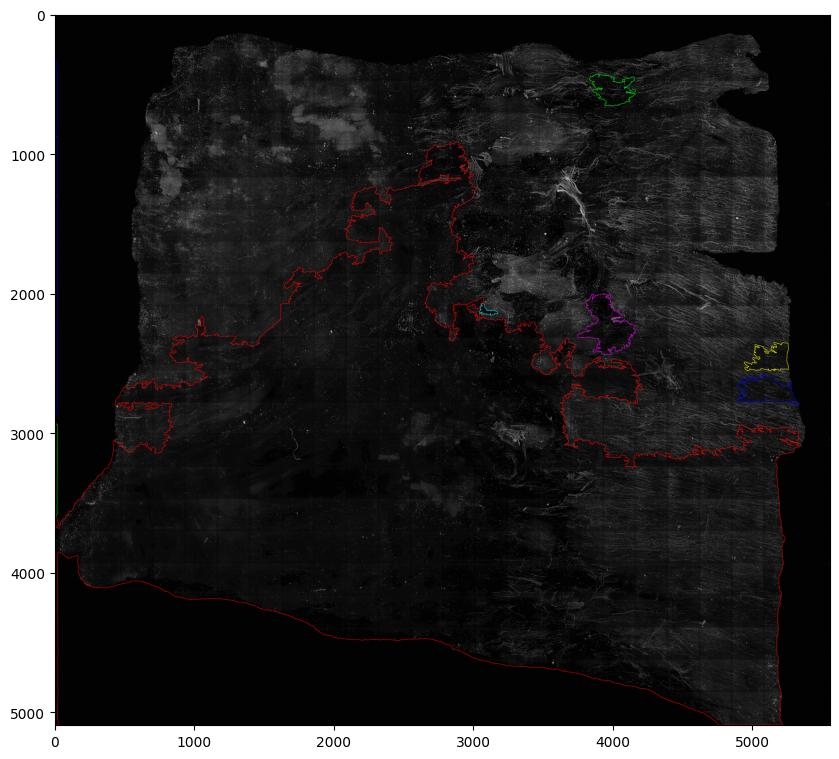

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(overlay)
